# <span style="color: #7A6B85;">Оглавление-ссылки на основные блоки</span>

[0. Библиотеки и пакеты](#biblioteks)

[1. Постановка задачи](#business_task)

[2. Гипотеза](#hipoteza)

[3. Правила принятия решения о внедрении модели](#criterion)

[4. Оценка базовых параметров](#retro_analyze)

[5. Статистическое планирование эксперимента методом Монте‑Карло](#monte_carlo)

[6. Обработка данных, анализ и интерпретация результатов](#experiment_data_analyze)

[Общие выводы](#final_conclusions)

[Реализация функций](#functions_code)



<a id="biblioteks"></a>
## <span style="color: #7A6B85;">0. Библиотеки и пакеты</span>

In [1]:
# Стандартные библиотеки
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Оптимизация и производительность
import numba
from joblib import Parallel, delayed

# Научные вычисления, статистические тесты и модели
from scipy.interpolate import interp1d
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.stats.proportion import proportion_confint

<a id="business_task"></a>
## <span style="color: #7A6B85;">1. Постановка задачи</span>

### <span style="color: #7A6B85;">1.1. Контекст</span>
ИТ-компания разрабатывает собственный поисковый движок. Одна из ключевых задач - <b>контроль релевантности</b> выдаваемого контента исходному запросу.

В текущей реализации:

* Качество поисковой выдачи оценивают <b>специалисты-асессоры</b>.

* Они вручную проверяют наиболее спорные результаты случайно выбранных запросов.

* Ответ кодируется бинарно:

    * 1 - выдача нерелевантна запросу;

    * 0 - выдача релевантна запросу.

Для снижения операционных затрат предложено <b>внедрить ML-модель</b>, которая автоматизирует проверку релевантности.


### <span style="color: #7A6B85;">1.2. Цель исследования</span>
Сравнить качество <b>ручной проверки</b> и <b>автоматизированной</b> (с помощью ML-модели)

### <span style="color: #7A6B85;">1.3. Требования бизнеса</span>
В ходе обсуждений с заказчиками выявлены следующие ограничения и приоритеты:

1. Равная важность precision и recall

    * Оба показателя критически значимы, нельзя жертвовать одним в пользу другого.

2. Сбалансированность классов

    * На оценку прежде всего попадают пограничные случаи, когда сложно понять, релевантна выдача или нет.

    * Доля нерелевантных выдач лежит в диапазоне $40-60\%$.

3. Недопустимость ухудшения качества

    * Даже незначительное снижение качества по сравнению с ручной проверкой - неприемлемо.

4. Экономическая целесообразность

    * Одной экономии на костах не достаточно, т.к. модель требует регулярных расходов на поддержку (дообучение, контроль качества).

    * Внедрение модели оправдано <b>только при росте качества</b>.

### <span style="color: #7A6B85;">1.4. Статистические параметры</span>
Для проверки гипотез заданы стандартные параметры:

* Уровень значимости: $\alpha = 0.05$

* Мощность теста: $1-\beta = 0.8$

### <span style="color: #7A6B85;">1.5. Выбор статистики и параметров теста</span>

1. Статистика

    * Выбрана $F_1$-мера, так как:

        * учитывает баланс precision и recall

        * интуитивно понятна бизнесу

        * адекватна про сбалансированных классах ($40-60\%$)

2. Тип статистического теста

    * Проводится <b>тест на превосходство</b> (superiority test): проверяем, что ML-модель строго лучше ручной проверки

3. MDE

    * MDE задаем равным $0.07$, т.к. на основе анализа окупаемости определили желаемый экономически обоснованный прирост качества: $\Delta F_1 = 0.07$

    * Такое значение MDE обеспечивает обнаружение значимых для бизнеса эффектов

<a id="hipoteza"></a>
## <span style="color: #7A6B85;">2. Гипотеза</span>
Для статистической проверки сформулированы гипотезы:

* $ H_{\text{0}}: \Delta F_{\text{1}} = F_{1}^{(ml)} - F_{1}^{(assessor)} \leq 0 $

    Интерпретация: ML-модель не превосходит ручную проверку

* $ H_{\text{1}}: \Delta F_{\text{1}} > 0 $

    Интерпретация: ML-модель статистически значимо лучше ручной проверки

<a id="criterion"></a>
## <span style="color: #7A6B85;">3. Правила принятия решения о внедрении модели</span>

### <span style="color: #7A6B85;">3.1. Статистический критерий (бутстрап)</span>
<b>Цель:</b> проверить гипотезу о превосходстве ML‑модели над ручной разметкой с помощью бутстрап‑метода.

<b>Исходные данные</b>

* Контрольный датасет $X^{(control)}$ размера $N$.

* Две выборки предсказаний:

    * $X^{(ml)}$ - результаты ML-модели,

    * $X^{(assessor)}$ - результаты ручной разметки.

<b>Шаги</b>

1. <b>Формирование бутстрап-выборок:</b>

    * Генерируем $B$ стратифицированных бутстрап-выборок $\{X_b^*\}_{b=1}^B$ из $X^{(control)}$

    * Для каждой выборки $X_b^*$ получаем соответствующие предсказания:

        * $X_b^{(ml)*}$ - предсказания ML-модели,

        * $X_b^{(assessor)*}$ - предсказания исполнителей.

2. <b>Расчет статистики для каждой бутстрап выборки:</b>

    * Для $b=1,...,B$:

        * Вычисляем $\widehat{F}_{1, b}^{(ml)*}$ на паре ($X_b^*, X_b^{(ml)*}$),

        * Вычисляем $\widehat{F}_{1, b}^{(assessor)*}$ на паре ($X_b^*, X_b^{(assessor)*}$),

        * Находим разницу $\Delta \widehat{F}_{1, b}^{*} = \widehat{F}_{1, b}^{(ml)*} - \widehat{F}_{1, b}^{(assessor)*}$

3. <b>Построение доверительного интервала:</b>

    * Сортируем $\{\Delta \widehat{F}_{1, b}^{*}\}_{b=1}^B$ по возрастанию.

    * Находим 5-й процентиль (для $\alpha=0.05$): $\ \ Lower_{0.05}=\Delta \widehat{F}_{1[\alpha=0.05]}^{*}$

    * Формируем односторонний доверительный интервал: [$Lower_{0.05}; 1$]

4. <b>Принятие решения:</b>

    * Если $Lower_{0.05} > 0$, отвергаем $H_0$ (модель статистически значимо лучше),

    * Иначе - нет достаточных оснований отвергнуть $H_0$

### <span style="color: #7A6B85;">3.2. Бизнес-критерий для внедрения</span>
Цель: проверить, что прирост качества модели достаточен для окупаемости ($\Delta F_1 \geq 0.07$)

<b>Шаги</b>
   
   1. <b>Оценка разности метрик на исходных данных:</b>

        * Вычисляем $\widehat{F_1}^{(ml)}$ На выборках ($X^{(control)}, X^{(ml)})$

        * Вычисляем $\widehat{F_1}^{(assessor)}$ На выборках ($X^{(control)}, X^{(assessor)})$

        * Находим разницу $\Delta \widehat{F_1} = \widehat{F_1}^{(ml)} - \widehat{F_1}^{(assessor)}$

   2. <b>Принятие решения:</b>

        * Если $\Delta \widehat{F_1} \geq 0.07$, то эффект считается достаточным для внедрения

        * Иначе - внедрение экономически нецелесообразно
        


### <span style="color: #7A6B85;">3.3. Итоговые правила принятия решения</span>

Модель внедряется, только если одновременно выполнены:
* <b>Статистический критерий:</b> $Lower_{0.05} > 0$ (значимое превосходство).
* <b>Бизнес-критерий:</b> $\Delta \widehat{F_1} \geq 0.07$ (достаточный прирост качества).

Если хотя бы одно условие не выполнено - модель не внедряется

___
[(ссылка на итоговые выводы по результатам А/Б-тестирования)](#final_conclusions)
___

<a id="retro_analyze"></a>
## <span style="color: #7A6B85;">4. Оценка базовых параметров</span>
включает в себя:
- Расчет соотношения классов, FPR, FNR
- Проверка стационарности, стабильности, наличия структурных сдвигов

### <span style="color: #7A6B85;">4.1. Подготовка данных</span>

In [16]:
# загрузим исторические данные за последние 5 месяцев, с 2023-06-07 по 2023-11-06
retro_data = pd.read_csv('retro_data.csv', parse_dates=True, index_col=0)
retro_data.head()

,true_class,assessor_class
2023-06-07,0,0
2023-06-07,1,1
2023-06-07,1,1
2023-06-07,0,1
2023-06-07,1,1


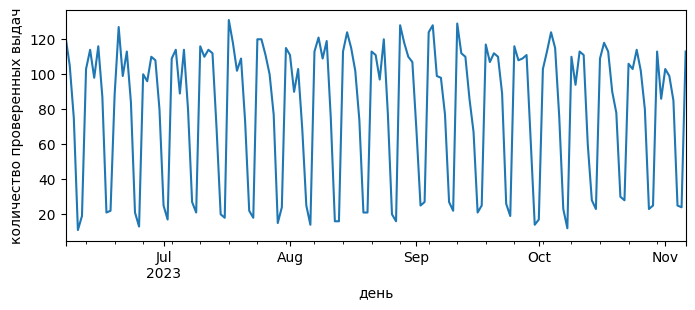

In [17]:
# оценим распределение количества данных по дням
plt.figure(figsize=(8, 3))
retro_data.groupby(retro_data.index)['true_class'].count().plot()
plt.xlabel('день')
plt.ylabel('количество проверенных выдач')
plt.show()


Выявлена недельная сезональность. Это связано с графиком работы специалистов, выполняющих задания: основная активность в будние дни по вечерам, а в выходные дни - отдых.

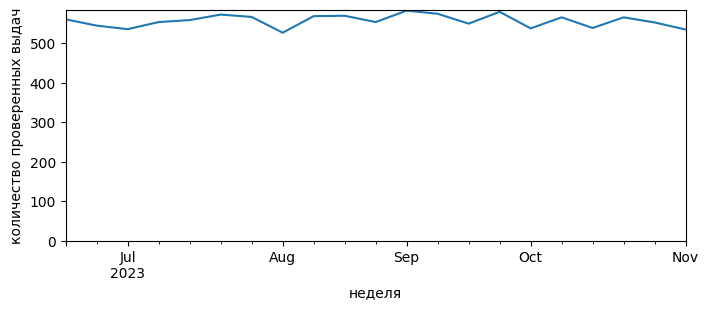

In [18]:
# Для устранения сезональности сгруппируем данные по неделям
# И исключим первую и последнюю недели, т.к. они могут быть неполными
plt.figure(figsize=(8, 3))
retro_data.resample('W')['true_class'].count().iloc[1:-1].plot()
plt.ylim(ymin=0)
plt.xlabel('неделя')
plt.ylabel('количество проверенных выдач')
plt.show()

На графике недельных данных явные признаки сезонности отсутствуют

рассчитаем параметры share_ones (доля положительного класса), FPR, FNR по недельным данным,
используя функцию <b>analyze_by_week()</b>
[(перейти к реализации и описанию)](#analyze_by_week)

In [19]:
analyzed_data = analyze_by_week(retro_data).iloc[1:-1]
analyzed_data.head()


,share_ones,FPR,FNR
week_start,,,
2023-06-12,0.467023,0.227425,0.148855
2023-06-19,0.442202,0.292763,0.219917
2023-06-26,0.457090,0.240550,0.175510
2023-07-03,0.472924,0.273973,0.213740
2023-07-10,0.443649,0.254019,0.213710


### <span style="color: #7A6B85;">4.2. Проверка параметров на стационарность (тесты ADF и KPSS)</span>
Проверяем, зависят ли параметры от времени

тесты обернуты в функцию <b>check_stationarity()</b>
[(перейти к реализации и описанию)](#check_stationarity)

In [20]:
# проверим стационарность параметра Доля положительного класса
check_stationarity(analyzed_data['share_ones'], alpha=0.05)

ADF p-value: 0.0073 → Стационарен
KPSS p-value: 0.1000 → Стационарен


In [21]:
# проверим стационарность параметра FPR
check_stationarity(analyzed_data['FPR'], alpha=0.05)

ADF p-value: 0.0000 → Стационарен
KPSS p-value: 0.0417 → Нестационарен


In [22]:
# проверим стационарность параметра FNR
check_stationarity(analyzed_data['FNR'], alpha=0.05)

ADF p-value: 0.0120 → Стационарен
KPSS p-value: 0.1000 → Стационарен


##### <span style="color: #6CA58D;">Вывод по стационарности параметров:</span>
- Высокая уверенность в стационарности парметров share_ones, FPR и FNR

### <span style="color: #7A6B85;">4.3. Проверка параметров на стабильность (кросс-валидация)</span>
Проверяет, что параметры не меняются сильно со временем

тест обернут в функцию <b>cv_stability()</b>
[(перейти к реализации и описанию)](#cv_stability)

In [23]:
# проверим стабильность параметра Доля положительного класса
cv_stability(analyzed_data['share_ones'], n_splits=5)

Относительное СКО по подвыборкам: 0.014
Стабильность: Да (порог 0.1)


In [24]:
# проверим стабильность параметра FPR
cv_stability(analyzed_data['FPR'], n_splits=5)

Относительное СКО по подвыборкам: 0.005
Стабильность: Да (порог 0.1)


In [25]:
# проверим стабильность параметра FNR
cv_stability(analyzed_data['FNR'], n_splits=5)

Относительное СКО по подвыборкам: 0.016
Стабильность: Да (порог 0.1)


##### <span style="color: #6CA58D;">Вывод по стабильности параметров:</span>
- Высокая уверенность в стабильности парметров FPR, FNR и share_ones (доля положительного класса)

### <span style="color: #7A6B85;">4.4. Проверка параметров на структурные сдвиги (тест Чоу)</span>
Проверяет, присутствуют ли точечные значимые изменения во временном ряде

тест обернут в функцию <b>chow_test()</b>
[(перейти к реализации и описанию)](#chow_test)

In [26]:
# проверим на наличие структурного сдвига параметра Доля положительного класса
chow_test(analyzed_data['share_ones'], breakpoint=5, alpha=0.05)

p-value: 0.7367 → отсутствие структурного сдвига


In [27]:
# проверим на наличие структурного сдвига параметра FPR
chow_test(analyzed_data['FPR'], breakpoint=5, alpha=0.05)

p-value: 0.7160 → отсутствие структурного сдвига


In [28]:
# проверим на наличие структурного сдвига параметра FNR
chow_test(analyzed_data['FNR'], breakpoint=5, alpha=0.05)

p-value: 0.4393 → отсутствие структурного сдвига


##### <span style="color: #6CA58D;">Вывод по наличию структурных сдвигов:</span>
- Высокая уверенность в отсутствии структурных сдвигов парметров FPR, FNR и share_ones (доля положительного класса)

### <span style="color: #7A6B85;">4.5. Усреднение базовых параметров</span>

Несмотря на стационарность и стабильность параметров, нам необходимы наиболее актуальные значения.
Поэтому для расчета итоговых значений параметров применим экспоненциально взвешенное среднее (EWMA). График обернут в функцию <b>plot_ewma()</b>
[(перейти к реализации и описанию)](#plot_ewma)


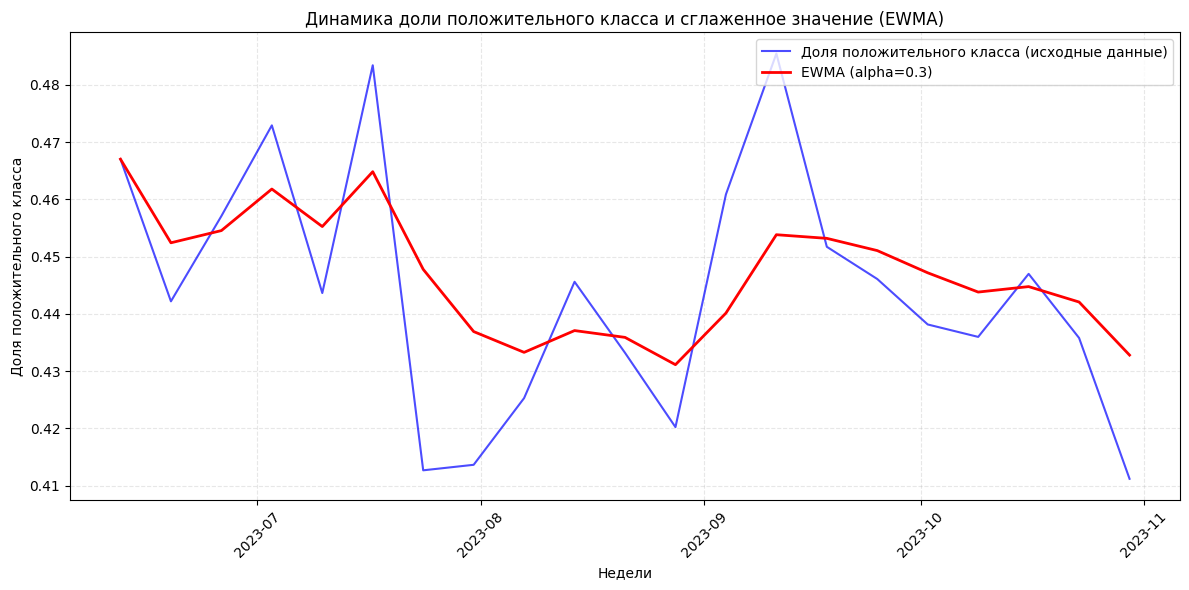

Усредненная доля положительного класса: 0.433


In [29]:
# рассчитаем EWMA для 'Доли положительного класса' и визуализируем для наглядности
plot_ewma(analyzed_data['share_ones'], alpha=0.3)
share_ones_ewma_last = analyzed_data['share_ones'].ewm(alpha=0.3).mean().iloc[-1]
print(f'Усредненная доля положительного класса: {share_ones_ewma_last:.3f}')

In [30]:
# по аналогии рассчитаем EWMA для FPR и FNR
fpr_ewma_last = analyzed_data['FPR'].ewm(alpha=0.3).mean().iloc[-1]
fnr_ewma_last = analyzed_data['FNR'].ewm(alpha=0.3).mean().iloc[-1]
print(f'Усредненный FPR: {fpr_ewma_last:.3f}')
print(f'Усредненный FNR: {fnr_ewma_last:.3f}')

Усредненный FPR: 0.261
Усредненный FNR: 0.197


<a id="monte_carlo"></a>
## <span style="color: #7A6B85;">5. Статистическое планирование эксперимента методом Монте‑Карло</span>
Моделирование реализовано в функции <b>mc_full()</b>
[(перейти к реализации и описанию)](#mc_full)

### <span style="color: #7A6B85;">5.1. A/A-тест</span>
рассмотрим два случая:
1. Идеальный случай, когда одинаковые параметры генерации выборок $ X^{(ml)} $ и $ X^{(assessor)} $
2. Реальный случай, когда в выборке $X^{(assessor)}$ один исполнитель размечает несколько поисковых выдач, т.к. у нас одновременно занимается разметкой ~40 специалистов. У каждого специалиста свое значение метрики F1.

In [31]:
# смоделируем первый случай, когда выборки для исполнителей и ml генерируются по одинаоквым правилам
# чем меньше выборка тем лучше, так как собирать и валидировать датасет довольно затратно
# будем отталкиваться от размера выборки 200 элементов
# значения share_ones, fnr_assessor, fpr_assessor оассчитали на основе исторических данных
x_control_len = 200
batch_assessor = x_control_len
assessor_prob_delta = 0.0
batch_assessor_prob = 1.0

results = mc_full(
    x_control_len=x_control_len, 
    share_ones=share_ones_ewma_last, 
    fnr_ml=fnr_ewma_last,
    fnr_assessor=fnr_ewma_last, 
    fpr_ml=fpr_ewma_last,
    fpr_assessor=fpr_ewma_last,
    assessor_prob_delta=assessor_prob_delta, 
    batch_assessor=batch_assessor,
    batch_assessor_prob=batch_assessor_prob,
    bootstrap_cnt=10_000,
    bootstrap_test=True,
    alpha=0.05,
    mc_size=5_000,
    stratify=True,
    master_seed=42)
    
mc_size = len(results)
q_alpha = np.array([x[0] for x in results])
out_ci_cnt = np.sum(q_alpha > 0)
fpr = round(out_ci_cnt / mc_size, 3)
fpr_lower, fpr_upper = proportion_confint(count = out_ci_cnt, nobs = mc_size, alpha=0.05, method='wilson')
avg_delta_f1 = round(np.mean(np.array([x[1] for x in results]).ravel()), 3)

print(f'fpr: {fpr}\nci: {[round(fpr_lower, 3), round(fpr_upper, 3)]}')
print(f'средняя разность F1_ml - F1_assessor: {avg_delta_f1}')


fpr: 0.049
ci: [0.043, 0.055]
средняя разность F1_ml - F1_assessor: -0.001


- Как видим, для идеального случая 1, когда выборки сгенерированы по одинаковой логике, значение $\alpha=0,05$ попадает в 95 % доверительный интервал $ FPR: [0.043, 0.055]$
- $\Delta F_{1} \approx 0$ свидетельствует об отсутствии систематической ошибки при генерации выборок для А/А-теста в идеальных условиях


In [32]:
# смоделируем второй случай, наиболее близкий к реальному, где у каждого исполнителя свое качество F1, несколько отличающееся от среднего
# одновременно для разметки доступны ~40 специалистов, поэтому разрешим одному специалисту разметить не более batch_assessor=15 заданий, чтобы минимизировать влияние конкретного специалиста на результат
# заложим, что качество разметки у исполнителей варьируется по закону fnr * (1 + np.random.uniform(-prob_delta, prob_delta)), для fpr аналогично
# количество заданий, размеченных исполнителем определим по биномиальному закону binom(15, 0.9)
x_control_len = 200
batch_assessor = 15
assessor_prob_delta = 0.5
batch_assessor_prob = 0.9

results = mc_full(
    x_control_len=x_control_len, 
    share_ones=share_ones_ewma_last, 
    fnr_ml=fnr_ewma_last,
    fnr_assessor=fnr_ewma_last, 
    fpr_ml=fpr_ewma_last,
    fpr_assessor=fpr_ewma_last,
    assessor_prob_delta=assessor_prob_delta, 
    batch_assessor=batch_assessor,
    batch_assessor_prob=batch_assessor_prob,
    bootstrap_cnt=10_000,
    bootstrap_test=True,
    alpha=0.05,
    mc_size=5_000,
    stratify=True,
    master_seed=42)
    
mc_size = len(results)
q_alpha = np.array([x[0] for x in results])
out_ci_cnt = np.sum(q_alpha > 0)
fpr = round(out_ci_cnt / mc_size, 3)
fpr_lower, fpr_upper = proportion_confint(count = out_ci_cnt, nobs = mc_size, alpha=0.05, method='wilson')
avg_delta_f1 = round(np.mean(np.array([x[1] for x in results]).ravel()), 3)

print(f'fpr: {fpr}\nci: {[round(fpr_lower, 3), round(fpr_upper, 3)]}')
print(f'средняя разность F1_ml - F1_assessor: {avg_delta_f1}')

fpr: 0.053
ci: [0.047, 0.06]
средняя разность F1_ml - F1_assessor: -0.002


- В реалистичном случае 2, когда в данных присутствует легкая зависимость (у каждого специалиста свой уровень качества), значение $\alpha=0,05$ также входит в 95 % ДИ FRP $[0.047, 0.06]$. Это свидетельствует о робастности критерия
- $\Delta F_{1} \approx 0$ свидетельствует об отсутствии систематической ошибки при генерации выборок для А/А-теста в реальных условиях

#### <span style="color: #6CA58D;">Вывод по А/А-тестам:</span>
- $ \alpha=0.05 $ лежит в 95\% ДИ FPR — критерий валиден

### <span style="color: #7A6B85;">5.2. A/B-тест. Оценка размера выборки</span>
За основу эксперимента принимается конфигурация из 2-го случая в A/A-теста

<b>Цель</b>

Определить минимальный размер выборки, при котором мощность теста достигает 80% при заданном MDE

<b>Шаги реализации</b>

1. Фиксируем необходимый MDE
2. Проводим серию тестов, варьируя размер выборки x_control_len
3. Для каждого x_control_len вычисляем достигаемую мощность при фиксированном MDE
4. Находим такой размер выборки x_control_len, при котором мощность равна 80% при необходимом MDE

In [33]:
# зададим функцию расчета теоретической F1
def _f1_theor(fnr, fpr, share_ones):
    recall = 1 - fnr
    precision = recall * share_ones / (recall * share_ones + fpr * (1 - share_ones))
    return 2 * precision * recall / (precision + recall)

# рассчитаем F1 на ретро-данных
f1_assessor = _f1_theor(fnr_ewma_last, fpr_ewma_last, share_ones_ewma_last)

# будем уменьшать fnr и fpr до тех пор, пока f1_new - f1_assessor не станет равно MDE
mde = 0.07
for step in np.arange(1.0, 0.1, -0.001):
    fnr_new = fnr_ewma_last * step
    fpr_new = fpr_ewma_last * step
    f1_new = _f1_theor(fnr_new, fpr_new, share_ones_ewma_last)
    if abs(f1_new - f1_assessor - mde) < 0.0001:
        print(f'F1_assessor: {f1_assessor:.3f}\nF1_ml: {f1_new:.3f}\nMDE: {f1_new - f1_assessor:.3f}\
              \nfnr_ml: {fnr_new:.3f}\nfpr_ml: {fpr_new:.3f}')
        fnr_ml = fnr_new
        fpr_ml = fpr_new
        break

F1_assessor: 0.749
F1_ml: 0.819
MDE: 0.070              
fnr_ml: 0.139
fpr_ml: 0.185


In [34]:
# переносим конфигурацию из А/А-теста, 2й случай
batch_assessor = 15
assessor_prob_delta = 0.5
batch_assessor_prob = 0.9



# исследуем зависимость мощности от размера выборки при фиксированном MDE=0.07 (fnr_ml=0.139, fpr_ml=0.185)

# будем уменьшать fnr и fpr для ML и смотреть, как меняется мощность
power_results = defaultdict(dict)
for x_control_len in [200, 300, 400, 500, 600]:

    results = mc_full(
        x_control_len=x_control_len, 
        share_ones=share_ones_ewma_last, 
        fnr_ml=fnr_ml,
        fnr_assessor=fnr_ewma_last, 
        fpr_ml=fpr_ml,
        fpr_assessor=fpr_ewma_last,
        assessor_prob_delta=assessor_prob_delta, 
        batch_assessor=batch_assessor,
        batch_assessor_prob=batch_assessor_prob,
        bootstrap_cnt=10_000,
        bootstrap_test=True,
        alpha=0.05,
        mc_size=5_000,
        stratify=True,
        master_seed=42)
    
    mc_size = len(results)
    q_alpha = np.array([x[0] for x in results])

    out_ci_cnt = np.sum(q_alpha > 0)
    power = round(out_ci_cnt / mc_size, 3)
    power_lower, power_upper = proportion_confint(count = out_ci_cnt, nobs = mc_size, alpha=0.05, method='wilson')
    mde_experimental = round(np.mean(np.array([x[1] for x in results])), 3)

    power_results[x_control_len]['power'] = power
    power_results[x_control_len]['power_lower'] = power_lower
    power_results[x_control_len]['power_upper'] = power_upper
    power_results[x_control_len]['mde_experimental'] = mde_experimental

Найдем размер выборки используя функцию power_vs_sample_size [(перейти к реализации и описанию)](#power_vs_sample_size)

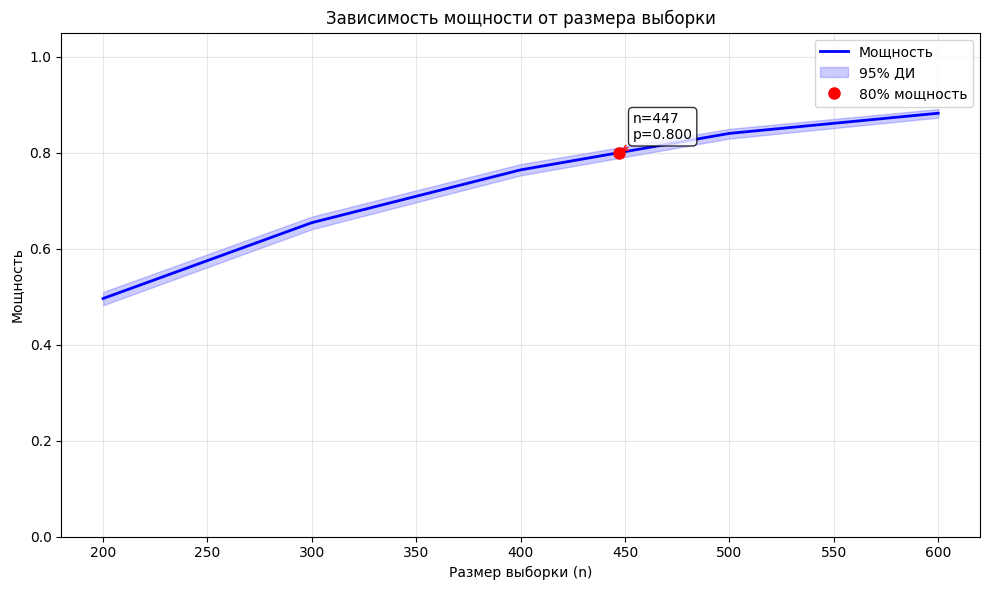

In [35]:
power_vs_sample_size(power_results)

### <span style="color: #6CA58D;"> Вывод по А/Б-тесту: </span>
- При размере выборки $x\_control\_len = 450$ тест имеет мощность $80 \%$ для $MDE = 0.07$
- ML-инженер должен ориентироваться на целевое качество модели $F_1^{(ml)}$ = 0.819

<a id="experiment_data_analyze"></a>
## <span style="color: #7A6B85;">6. Обработка данных, анализ и интерпретация результатов</span>

Эксперимент длился 5 дней, с 2023-11-20 по 2023-11-24. На выходе имеем датасет из 450 размеченных заданий. По каждому заданию знаем правильный ответ, ответ исполнителя и ответ алгоритма

In [36]:
# подгрузим данные, собранные в ходе проведения А/Б-теста
a_b_test_data = pd.read_csv('a_b_test_data.csv', parse_dates=True, index_col=0)
a_b_test_data.head()

,true_class,assessor_class,ml_class
2023-11-20,0,0,0
2023-11-20,1,1,1
2023-11-20,0,0,0
2023-11-20,0,0,0
2023-11-20,0,0,0


### <span style="color: #7A6B85;">6.1. Сравним значения параметров теста с полученными на ретро-данных</span>

In [37]:
# так как оба дня проведения теста попадают на одну неделю, то переиспользуем функцию расчета параметров по неделям
test_parameters = analyze_by_week(a_b_test_data)
test_parameters

,share_ones,FPR,FNR
week_start,,,
2023-11-20,0.462222,0.289256,0.177885


In [38]:
# сравним ретро-значения параметров VS тестовые
print(f'share_ones: было {share_ones_ewma_last:.3f} VS стало {test_parameters['share_ones'].iloc[0]:.3f}')
print(f'FPR: было {fpr_ewma_last:.3f} VS стало {test_parameters['FPR'].iloc[0]:.3f}')
print(f'FNR: было {fnr_ewma_last:.3f} VS стало {test_parameters['FNR'].iloc[0]:.3f}')

share_ones: было 0.433 VS стало 0.462
FPR: было 0.261 VS стало 0.289
FNR: было 0.197 VS стало 0.178


### <span style="color: #6CA58D;"> Выводы по параметрам: </span>
- ключевые параметры изменились не существенно, система работает стабильно
- условия эксперимента соответствуют валидированной модели
- можно говорить о контроле ошибки первого рода на уровне $\alpha=0.05$

In [39]:
# сравним значение F1-мер на тестовом датасете, ретро данных и сравним с целевым
f1_assessor_test = f1_score(a_b_test_data['true_class'], a_b_test_data['assessor_class'])
f1_ml_test = f1_score(a_b_test_data['true_class'], a_b_test_data['ml_class'])
print(f'F1 исполнителей на ретро-данных: {round(f1_assessor, 3)}')
print(f'F1 исполнителей на тесте: {round(f1_assessor_test, 3)}')
print(f'F1 ML-алгоритма на тесте: {round(f1_ml_test, 3)}')
print(f'F1 целевой для ML-алгоритма: {round(f1_assessor + 0.07, 3)}')

F1 исполнителей на ретро-данных: 0.749
F1 исполнителей на тесте: 0.762
F1 ML-алгоритма на тесте: 0.841
F1 целевой для ML-алгоритма: 0.819


### <span style="color: #6CA58D;"> Выводы по метрике: </span>
- На тестовом датасете ML-классификатор достиг требуемой бизнес-цели $F_1$ (тест 0.841 >  цель 0.819)
- Метрика $F_1$ исполнителей выросла (было 0.749 на ретро-данных, стало 0.762 на тесте). Это может говорить либо о сдвиге распределения данных, либо об улучшении качества самих исполнителей, либо о статистической погрешности из-за ограниченного размера тестовой выборки
- Фактическая $\Delta F_1$ между ML-классификатором и исполнителями на тестовом датасете составила 0.079 (0.841 - 0.762), что превышает минимально требуемый для окупаемости прирост 0.07. Это дополнительно обосновывает целесообразность внедрения модели
- Наблюдаемый прирост $\Delta F_1 = 0.079$ превышает MDE = 0.07, заложенный в априорную оценку мощности. При прочих равных реальная мощность теста будет выше запланированной

### <span style="color: #7A6B85;">6.2. Проверим критерий на тестовых данных</span>

Построим ДИ для $ \Delta \widehat{F}_{1}^{*}$ с помощью  функции f1_diffs_ab_test [(перейти к реализации и описанию)](#f1_diffs_ab_test) и функции plot_f1_diff_density [(перейти к реализации и описанию)](#plot_f1_diff_density)

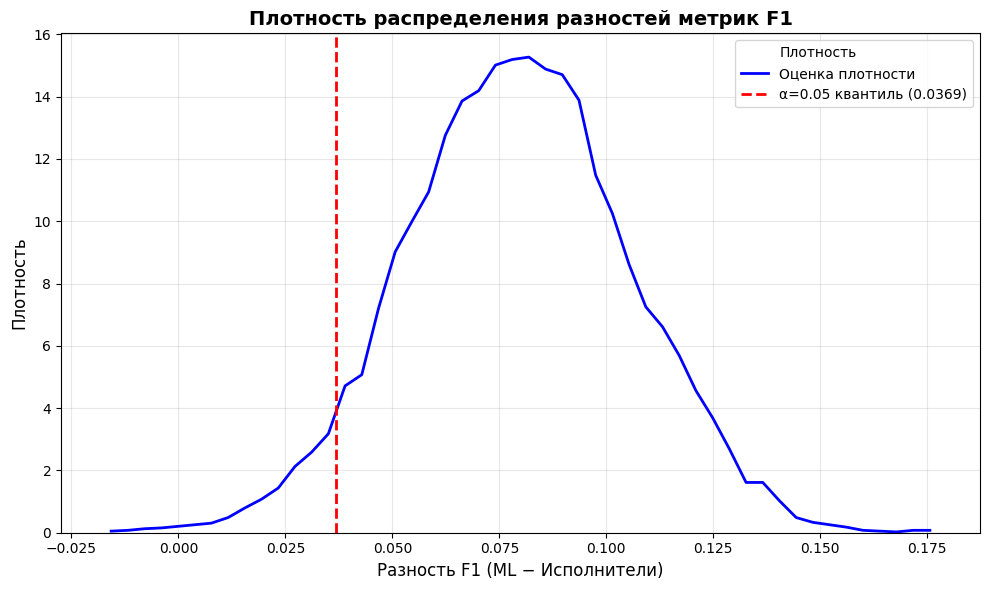

In [40]:
# строим доверительный интервал разности F1 и сравниваем с 0
f1_diffs_test = f1_diffs_ab_test(a_b_test_data, n=500, bootstrap_cnt=10000, seed=42)
plot_f1_diff_density(f1_diffs_test, alpha=0.05, figsize=(10, 6))

### <span style="color: #6CA58D;"> Вывод по статистическому критерию: </span>
- $ \Delta \widehat{F}_{1[\alpha]}^{*} = 0.037 >> 0 \to$ уверенно отвергаем $H_0$

<a id="final_conclusions"></a>
___
# <span style="color: #E07161;"><b>Общие выводы</b></span>
1. <b>ML‑модель превосходит ручную проверку по качеству.</b> На тестовом датасете модель достигла $F_1 = 0.841$, что выше целевого значения $0.819$ и значительно превышает результат исполнителей ($F_1 = 0.762$).
2. <b>Наблюдаемый прирост значим для бизнеса.</b> Разница $\Delta F_1 = 0.079$ (между моделью и исполнителями) превышает минимально необходимый порог окупаемости $\Delta F_1 = 0.07$.
3. <b>Тест статистически валиден:</b>
    - мощность теста при выборке 450 наблюдений составляет 80% для $MDE = 0.07$, что покрывает требуемый эффект $0.07$;
    - уровень значимости $\alpha = 0.05$ контролируется (подтверждено А/А-тестами);
    - нулевая гипотеза уверенно отвергается $ \Delta \widehat{F}_{1[\alpha]}^{*} = 0.037 >> 0$
4. <b>Система стабильна.</b> Параметры $FPR, FNR$ и доля положительного класса $share\_ones$ демонстрируют в ходе тестов:
    - стационарность;
    - отсутствие структурных сдвигов;
    - высокую стабильность.
5. <b>Внедрение экономически обосновано.</b> Модель не только экономит затраты на ручную проверку, но и обеспечивает <b>значимый рост качества</b>, что соответствует бизнес требованиям.

<b>Итог:</b> результаты А/Б-теста подтверждают целесообразность внедрения ML-модели для автоматизированной проверки релевантности поисковой выдачи.
___


<a id="functions_code"></a>
## <span style="color: #7A6B85;">Реализация функций</span>

<a id="analyze_by_week"></a>
#### функция расчета недельных параметров analyze_by_week()

In [2]:
def analyze_by_week(df):
    """
    Группирует данные по неделям и вычисляет:
    - долю единиц;
    - FPR;
    - FNR
    """
    # Группируем по неделям (начало недели — понедельник)
    df['week_start'] = df.index.to_period('W').start_time
    weekly = df.groupby('week_start')
    
    
    def calculate_metrics(group):
        y_true = group['true_class']
        y_pred = group['assessor_class']
        # Доля единиц в правильных ответах
        pos_rate = y_true.mean()
        # FPR: доля ложных срабатываний (предсказано 1, а правда 0)
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        tn = ((y_pred == 0) & (y_true == 0)).sum()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        # FNR: доля пропущенных срабатываний (предсказано 0, а правда 1)
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        return pd.Series({
            'share_ones': pos_rate,
            'FPR': fpr,
            'FNR': fnr
        })
    
    
    return weekly.apply(calculate_metrics, include_groups=False
                        )

<a id="check_stationarity"></a>
#### функция тестов на стационарность check_stationarity()

In [3]:
def check_stationarity(series, alpha=0.05):
    # ADF тест
    adf_result = adfuller(series)
    adf_p = adf_result[1]
    # KPSS тест
    warnings.simplefilter('ignore', InterpolationWarning)
    kpss_result = kpss(series, regression='c')
    kpss_p = kpss_result[1]
    print(f"ADF p-value: {adf_p:.4f} → {'Стационарен' if adf_p <= alpha else 'Нестационарен'}")
    print(f"KPSS p-value: {kpss_p:.4f} → {'Стационарен' if kpss_p > alpha else 'Нестационарен'}")

<a id="cv_stability"></a>
#### функция проверки на стабильность cv_stability()

In [4]:
def cv_stability(series, n_splits=5, threshold=0.1):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    means = []
    for train_idx, _ in tscv.split(series):
        train_data = series.iloc[train_idx]
        means.append(train_data.mean())
    relative_std = np.std(means) / np.mean(means)
    print(f'Относительное СКО по подвыборкам: {relative_std:.3f}')
    is_stable = relative_std < threshold
    print(f'Стабильность: {"Да" if is_stable else "Нет"} (порог {threshold})')

<a id="chow_test"></a>
#### функция теста на структурные сдвиги chow_test()

In [5]:
def chow_test(series, breakpoint=None, alpha=0.05):
    n = len(series)
    if breakpoint is None:
        breakpoint = n // 2
    if breakpoint < 5 or (n - breakpoint) < 5:
        print("Слишком мало данных для теста Чоу")
        return False
    
    t = np.arange(n)
    y = series.values
    X = add_constant(t)
    
    # Полная модель
    full_model = OLS(y, X).fit()
    # Модели для подвыборок
    X1, y1 = X[:breakpoint], y[:breakpoint]
    X2, y2 = X[breakpoint:], y[breakpoint:]
    model1 = OLS(y1, X1).fit()
    model2 = OLS(y2, X2).fit()
    
    # Статистика Чоу
    ssr_full = full_model.ssr
    ssr_split = model1.ssr + model2.ssr
    chow_stat = ((ssr_full - ssr_split) / 2) / (ssr_split / (n - 4))
    from scipy.stats import f
    p_value = f.sf(chow_stat, 2, n - 4)
    
    print(f'p-value: {p_value:.4f} → {"отсутствие структурного сдвига" if p_value > alpha else "присутствие структурного сдвига"}')

<a id="mc_full"></a>
## Реализация mc_full()

In [6]:
def _split_array(np_array, batch_max=20, p=0.9, random_state=None):
    '''
    Эта функция разбивает исходный массив на подмассивы размером до batch_max >= 1
    '''

    if isinstance(random_state, np.random.Generator):
        rng = random_state
    else:
        rng = np.random.default_rng(random_state)

    result = []
    n = len(np_array)
    left = 0
    right = 0
    while right < n:
        size = rng.binomial(batch_max, p)
        if size == 0:
            size = 1
        right = min(left + size, n)
        result.append(np_array[left:right])
        left = right
    return result

In [7]:
def _flip_elements(array_of_arrays, fnr=0.15, fpr=0.10, prob_delta=0.1, random_state=None):
    '''
    Переворачивает элементы из 1 в 0 и обратно с заданными вероятностями.
    Можно задать отклонения вероятностей между подмассивами.
    '''

    if isinstance(random_state, np.random.Generator):
        rng = random_state
    else:
        rng = np.random.default_rng(random_state)

    fliped_result = []
    for elem in array_of_arrays:
        # задаем вероятности переворотов для подмассивов (как будто один исполнитель размечает несколько запросов)
        fnr_new = fnr * (1 + rng.uniform(-prob_delta, prob_delta))
        fpr_new = fpr * (1 + rng.uniform(-prob_delta, prob_delta))
        local_result = elem.copy()
        # переворачиваем 1 в 0 с вероятностью fnr_new
        flip_1_to_0 = (elem == 1) & (rng.random(elem.shape) < fnr_new)
        local_result[flip_1_to_0] = 0
        # переворачиваем 0 в 1 с вероятностью fpr_new
        flip_0_to_1 = (elem == 0) & (rng.random(elem.shape) < fpr_new)
        local_result[flip_0_to_1] = 1
        fliped_result.append(local_result)
    return np.concatenate(fliped_result, axis=0)

In [8]:
# зададим функцию генерации индексов для бутстрап подвыборок с учетом стратификации классов
def paired_stratified_bootstrap_idxs_optimized(x_control, bootstrap_cnt, stratify=True, random_state=None):
    
    if isinstance(random_state, np.random.Generator):
        rng = random_state
    else:
        rng = np.random.default_rng(random_state)
    
    n = len(x_control)
    
    if stratify:
        # Создаём итоговый массив
        bootstrap_indices = np.zeros((bootstrap_cnt, n), dtype=int)
        # Проходим по каждому классу (0 и 1)
        for cls in np.unique(x_control):
            # Получаем позиции, где встречается класс `cls`
            positions = np.where(x_control == cls)[0]
            class_size = len(positions)
            # Генерируем выборки: для каждой из bootstrap_cnt итераций выбираем class_size индексов
            # с заменой из списка `positions`
            chosen = rng.choice(
                positions,                    # выбираем из реальных позиций класса
                size=(bootstrap_cnt, class_size),
                replace=True
            )
            # Размещаем выбранные индексы в правильные столбцы для всех выборок
            bootstrap_indices[:, positions] = chosen
    else:
        bootstrap_indices = rng.integers(n, size=(bootstrap_cnt, n))
    
    return bootstrap_indices

In [9]:
# оптимизируем вычисление метрик F1 при бутстрапе с помощью numba
@numba.njit(parallel=True)
def _f1_diffs_numba(x_control, x_ml, x_assessor, bootstrap_cnt, bootstrap_indices) -> np.ndarray:
    """
    Функция генерирует бутстрап‑выборки и считает разности метрик F1.
    Параметры:
    - x_control, x_ml, x_assessor: массивы бинарных меток (0/1)
    - bootstrap_cnt: число бутстрап‑итераций
    - bootstrap_indices: массив индексов для бутстрапа (shape = (bootstrap_cnt, n))
    Возвращает:
    - Массив разностей F1 (длина bootstrap_cnt)
    """
    n = len(x_control)
    f1_diffs = np.empty(bootstrap_cnt, dtype=np.float64)

    # Вспомогательная функция расчёта F1 по индексам
    def _calc_f1(labels_true, labels_pred, indices):
        tp = 0
        fp = 0
        fn = 0
        for j in range(n):
            idx = indices[j]
            if labels_true[idx] == 1:
                if labels_pred[idx] == 1:
                    tp += 1
                else:
                    fn += 1
            else:
                if labels_pred[idx] == 1:
                    fp += 1
        tp_fp = tp + fp
        tp_fn = tp + fn
        precision = tp / tp_fp if tp_fp > 0 else 0.0
        recall = tp / tp_fn if tp_fn > 0 else 0.0
        if (precision + recall) > 0.0:
            f1 = 2.0 * precision * recall / (precision + recall)
        else:
            f1 = 0.0
        return f1


    for i in numba.prange(bootstrap_cnt):
        idx_ml = bootstrap_indices[i, :]
        idx_assessor = bootstrap_indices[i, :] 
        f1_ml = _calc_f1(x_control, x_ml, idx_ml)
        f1_assessor = _calc_f1(x_control, x_assessor, idx_assessor)
        f1_diffs[i] = f1_ml - f1_assessor
    return f1_diffs


# вариант, когда бутстрап не нужен, а нужно просто фактическое значение дельты f1
def _f1_diffs_wo_bootstrap(x_control, x_ml, x_assessor):
    return np.array([f1_score(x_control, x_ml) - f1_score(x_control, x_assessor)])


# итоговая функция бутстрапа
def _f1_diffs_bootstrap(x_control, x_ml, x_assessor, bootstrap_cnt=10_000, bootstrap_test=True, stratify=True, random_state=None):
    if bootstrap_test:
        # генерируем индексы для парного стратифицированного бутстрапа
        bootstrap_indices = paired_stratified_bootstrap_idxs_optimized(x_control, bootstrap_cnt, stratify, random_state)
        # передаем в функцию расчета метрик F1 для бутстрапа массив индексов и явно приводим типы входных данных для numba
        x_control = x_control.astype(np.int64)
        x_ml = x_ml.astype(np.int64)
        x_assessor = x_assessor.astype(np.int64)
        result = _f1_diffs_numba(x_control, x_ml, x_assessor, bootstrap_cnt, bootstrap_indices)
    else:
        result = _f1_diffs_wo_bootstrap(x_control, x_ml, x_assessor)
    return result

In [10]:
# зададим функцию для проведения 1й итерации метода Монте-Карло
def mc_iteration(
        x_control_len=100, 
        share_ones=0.3, 
        fnr_ml=0.20,
        fnr_assessor=0.20, 
        fpr_ml=0.1,
        fpr_assessor=0.1,
        assessor_prob_delta=0.1, 
        batch_assessor=20,
        batch_assessor_prob=1.0,
        bootstrap_cnt=10_000,
        bootstrap_test=True,
        stratify=True,
        alpha=0.05,
        seed=None):
    
    rng = np.random.default_rng(seed)

    # моделируем контрольный датасет
    x_control = rng.binomial(1, share_ones, x_control_len)
    # моделируем разметку ML, как будто один асессор разметил все запросы с одинаковыми вероятностями fpr и fnr
    x_ml = _split_array(x_control, batch_max=x_control_len, p=1.0, random_state=rng)
    x_ml = _flip_elements(x_ml, fnr=fnr_ml, fpr=fpr_ml, prob_delta=0.0, random_state=rng)
    # моделируем разметку исполнителями, как будто каждый исполнитель может разметить несколько заданий (до batch) и у каждого исполнителя свои вероятности fpr и fnr
    x_assessor = _split_array(x_control, batch_max=batch_assessor, p=batch_assessor_prob, random_state=rng)
    x_assessor = _flip_elements(x_assessor, fnr=fnr_assessor, fpr=fpr_assessor, prob_delta=assessor_prob_delta, random_state=rng)
    # считаем бутстрап-разности f1
    f1_diffs = _f1_diffs_bootstrap(x_control, x_ml, x_assessor, bootstrap_cnt, bootstrap_test, stratify, random_state=rng)
    # считаем дельту f1, соответствующую стат. значимости альфа
    q_alpha = np.quantile(f1_diffs, alpha)
    return q_alpha, f1_diffs

In [11]:
# функция для проведения метода Монте-Карло
def mc_full(
        x_control_len=100, 
        share_ones=0.3, 
        fnr_ml=0.20,
        fnr_assessor=0.20, 
        fpr_ml=0.1,
        fpr_assessor=0.1,
        assessor_prob_delta=0.1, 
        batch_assessor=20,
        batch_assessor_prob=1.0,
        bootstrap_cnt=10_000,
        bootstrap_test=True,
        stratify=True,
        alpha=0.05,
        mc_size=1000,
        master_seed=42):
        '''
        * x_control_len - размер контрольной выборки
        * share_ones - доля единиц в контрольной выборке (1 - это минорный класс, когда выдача не релевантна запросу)
        * fnr_ml - вероятность, с которой ML алгоритм ошибочно определяет нерелевантную выдачу как релевантную (0 вместо 1)
        * fnr_assessor - вероятность, с которой assessor ошибочно определяет нерелевантную выдачу как релевантную (0 вместо 1)
        * fpr_ml - вероятность, с которой ML алгоритм ошибочно определяет релевантную выдачу как нерелевантную (1 вместо 0)
        * fpr_assessor - вероятность, с которой assessor ошибочно определяет релевантную выдачу как нерелевантную (1 вместо 0)
        * assessor_prob_delta - максимально возможное отклонение по вероятности fnr_assessor и fpr_assessor для каждого отдельного исполнителя \
                отклонение задается равномерно на отрезке [-assessor_prob_delta; assessor_prob_delta]
        * batch_assessor - максимальное количество выдач, которые может разметить один исполнитель
        * batch_assessor_prob - параметр в полуинтервале (0; 1] чем ближе к 1, тем больше вероятность, что исполнитель разметит максимальное количество выдач, равное batch_assessor
        * bootstrap_cnt - количество генерируемых бутстрап-подвыборок для каждой пары выборок {x_control; x_ml} и {x_control; x_assessor}
        * bootstrap_test - если False, то бутстрап-тест не проводится, а считается фактическая дельта f1, независимо от значения параметра bootstrap_cnt
        * alpha - уровень значимости (пороговая вероятность ошибки первого рода)
        * mc_size - количество итераций метода Монте-Карло

        Возвращает массив дельт F1_ml - F1_assessor, квантиль дельт 1-альфа
        '''

        seed_seq = np.random.SeedSequence(master_seed)
        task_seeds = seed_seq.generate_state(mc_size)

        results = Parallel(n_jobs=-1, verbose=0)(
                delayed(mc_iteration)(x_control_len=x_control_len, 
                                      share_ones=share_ones, 
                                      fnr_ml=fnr_ml, 
                                      fnr_assessor=fnr_assessor, 
                                      fpr_ml=fpr_ml,
                                      fpr_assessor=fpr_assessor,
                                      assessor_prob_delta=assessor_prob_delta,
                                      batch_assessor=batch_assessor,
                                      batch_assessor_prob=batch_assessor_prob,
                                      bootstrap_cnt=bootstrap_cnt,
                                      bootstrap_test=bootstrap_test,
                                      stratify=stratify,
                                      alpha=alpha,
                                      seed=seed)
                for seed in task_seeds
        )
        return results

<a id="f1_diffs_ab_test"></a>
## Реализация f1_diffs_ab_test()

In [12]:
def f1_diffs_ab_test(a_b_test_data, n, bootstrap_cnt, seed):

    def _bootstrap_stratified_idxs(bootstrap_cnt, n, true_class, rng):
        # Генерируем индексы для стратифицированных бутстрап подвыборок
        bootstrap_indices = np.zeros((bootstrap_cnt, n), dtype=int)
        # Проходим по каждому классу (0 и 1)
        for cls in np.unique(true_class):
            # Получаем позиции, где встречается класс `cls`
            positions = np.where(true_class == cls)[0]
            class_size = len(positions)
            # Генерируем выборки: для каждой из bootstrap_cnt итераций выбираем class_size индексов
            # с заменой из списка `positions`
            chosen = rng.choice(
                positions,
                size=(bootstrap_cnt, class_size),
                replace=True
                )
            # Размещаем выбранные индексы в правильные столбцы для всех выборок
            bootstrap_indices[:, positions] = chosen
        return bootstrap_indices


    rng = np.random.default_rng(seed)
    true_class = a_b_test_data['true_class']
    idxs = _bootstrap_stratified_idxs(bootstrap_cnt, n, true_class, rng)
    x_control = a_b_test_data['true_class'].values.astype(np.int64)
    x_ml = a_b_test_data['ml_class'].values.astype(np.int64)
    x_assessor = a_b_test_data['assessor_class'].values.astype(np.int64)
    result = _f1_diffs_numba(x_control, x_ml, x_assessor, bootstrap_cnt, idxs)
    return result

## Реализация графиков

<a id="power_vs_sample_size"></a>
### power_vs_sample_size()

In [13]:
def power_vs_sample_size(power_dict):
    sizes, powers = zip(*sorted(power_dict.items()))
    powers, lower, upper = zip(*[(v['power'], v['power_lower'], v['power_upper']) for v in powers])
    
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, powers, 'b-', lw=2, label='Мощность')
    plt.fill_between(sizes, lower, upper, color='blue', alpha=0.2, label='95% ДИ')
    
    try:
        f = interp1d(powers, sizes, kind='linear')
        n80 = int(f(0.8))
        p80 = float(interp1d(sizes, powers)(n80))
        plt.plot(n80, p80, 'ro', ms=8, label='80% мощность')
        plt.annotate(f'n={n80}\np={p80:.3f}', (n80, p80), xytext=(10,10), 
                    textcoords='offset points', bbox=dict(boxstyle='round,pad=0.3',
                    facecolor='white', alpha=0.8), arrowprops=dict(arrowstyle='->',color='red'))
    except:
        n80 = None

    plt.xlabel('Размер выборки (n)'); plt.ylabel('Мощность'); plt.title('Зависимость мощности от размера выборки')
    plt.grid(True, alpha=0.3); plt.legend(); plt.ylim(0, 1.05); plt.tight_layout(); plt.show()

<a id="plot_ewma"></a>
### plot_ewma()

In [14]:
def plot_ewma(data, alpha=0.1, figsize=(12, 6)):
    """
    Строит график исходных данных и их EWMA-сглаживания.
    
    Параметры:
    - data: pd.Series с данными
    - alpha: параметр сглаживания EWMA (по умолчанию 0.1)
    - figsize: размер графика (по умолчанию (12, 6))
    """
    ewma = data.ewm(alpha=alpha).mean()
    
    plt.figure(figsize=figsize)
    plt.plot(data.index, data, label='Доля положительного класса (исходные данные)', color='blue', alpha=0.7)
    plt.plot(data.index, ewma, label=f'EWMA (alpha={alpha})', color='red', linewidth=2)
    plt.xlabel('Недели')
    plt.ylabel('Доля положительного класса')
    plt.title('Динамика доли положительного класса и сглаженное значение (EWMA)')
    plt.legend()
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<a id="plot_f1_diff_density"></a>
### plot_f1_diff_density()

In [15]:
def plot_f1_diff_density(diffs, alpha=0.05, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    # Оценка плотности и построение кривой
    density, bins, _ = plt.hist(diffs, bins=50, density=True, alpha=0, label='Плотность')
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    plt.plot(bin_centers, density, color='blue', linewidth=2, label='Оценка плотности')
    # Квантиль alpha (левый хвост)
    q_alpha = np.quantile(diffs, alpha)
    plt.axvline(q_alpha, color='red', linestyle='--', linewidth=2, 
               label=f'α={alpha} квантиль ({q_alpha:.4f})')
    plt.xlabel('Разность F1 (ML − Исполнители)', fontsize=12)
    plt.ylabel('Плотность', fontsize=12)
    plt.title('Плотность распределения разностей метрик F1', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()